In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

import sys
sys.path.insert(0,'../src/')

from utils import *
from multiply_connected_pipe import *
from pipe_system import PipeSystem
from abstract_pipe import *

In [2]:
# with open('pipes_and_shifts.pickle','rb') as f:
#     pipes, shifts = pickle.load(f)
with open('v0.pickle','rb') as f:
    pipes_and_shifts = pickle.load(f)
    pipes = [p for p,_ in pipes_and_shifts]
    shifts = [s for _,s in pipes_and_shifts]
    
with open('global_built.pickle', 'rb') as f:
    global_pipe = pickle.load(f)
 

In [3]:
for pipe in set(pipes):
    for p in pipe.panels:
            p._build()
    pipe.build_pressure_drops()
    pipe.build_plotting_data(density=5)

/home/haiy/pkg/fmm2d/python/fmm2dpy/fmm2d.py:894: ComplexWarning: Casting complex values to real discards the imaginary part
  out.pottarg,out.gradtarg,out.ier = lfmm.cfmm2d_t_d_g(eps,sources,dipstr,targets)


In [4]:
for p in global_pipe.panels: p._build()
global_pipe.build_pressure_drops()

In [5]:
bdr_pipe = BoundaryPipe([BoundaryLet(-200,0,0,4,-1),BoundaryLet(248,0,np.pi,4,1)])
real_pipes = [RealPipe(p,shift_x=shift[0],shift_y=shift[1]) for p,shift in zip(pipes,shifts)]
lets = sorted([l for p in real_pipes for l in p.lets], key=lambda l: l.x)

In [6]:
ps = PipeSystem(real_pipes,bdr_pipe)

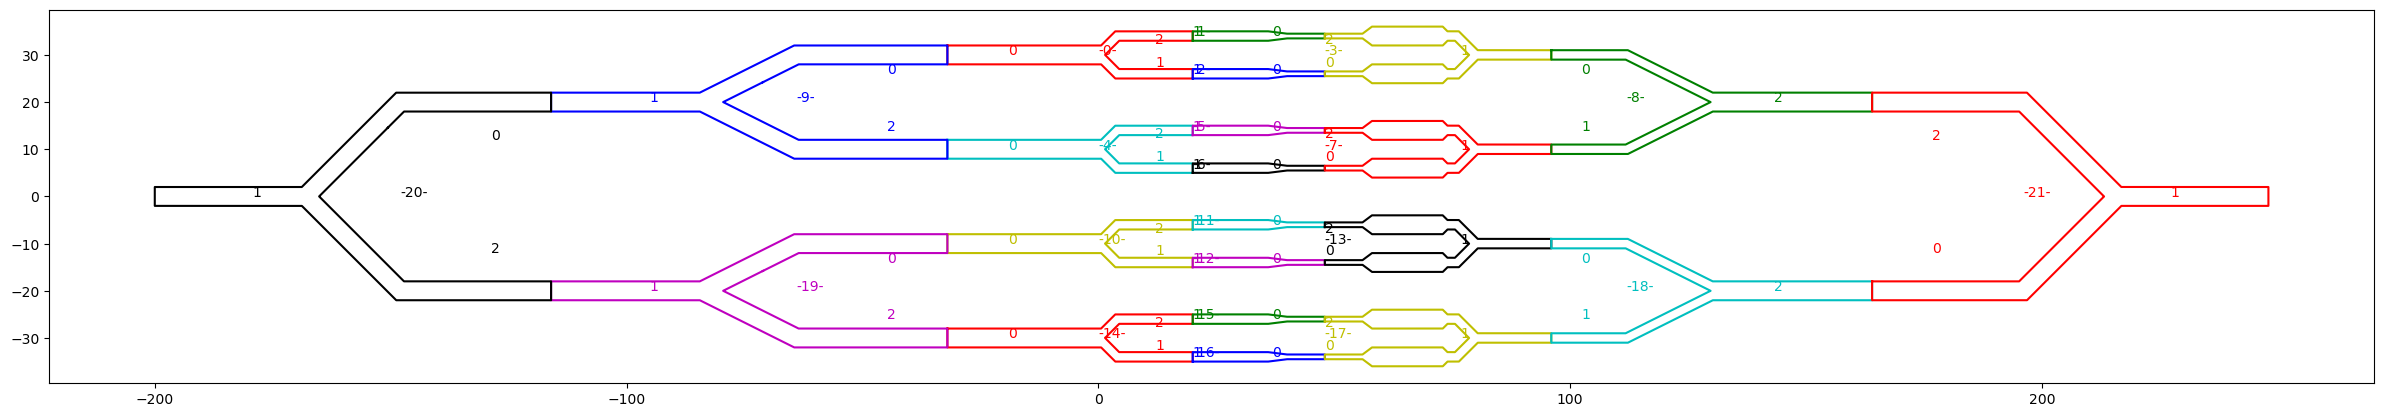

In [7]:
color = 'rgbycmk'*10

fig,ax = plt.subplots(figsize=(30,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(22),pipes,shifts,color):
    ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,c=c)
    for k,let in enumerate(i.lets):
        ax.text(*(0.6*let.matching_pt + j),f'{k}',color=c)
    ax.text(*j,f'-{a}-',color=c)

In [8]:
xs, ys, u_field, v_field, p_field, o_field = ps.plotting_data()

In [9]:
from scipy.interpolate import griddata

def interpolate(xs,ys,u,v):
    xi = np.linspace(xs.min(), xs.max(), np.ceil(5*(xs.max()-xs.min())).astype(int))
    yi = np.linspace(ys.min(), ys.max(), np.ceil(5*(ys.max()-ys.min())).astype(int))

    xi, yi = np.meshgrid(xi,yi)

    #then, interpolate your data onto this grid:

    pts = np.array([xs.ravel(),ys.ravel()]).T
    u_values = u.ravel()
    v_values = v.ravel()

    ui = griddata(pts, u_values, (xi,yi), method='linear')
    vi = griddata(pts, v_values, (xi,yi))

    return xi, yi, ui, vi

In [10]:
xi,yi,ui,vi = interpolate(xs,ys,u_field,v_field)

In [11]:
mask = global_pipe.inside(xi.ravel(),yi.ravel()).reshape(xi.shape)

In [12]:
ui[~mask] = np.nan
vi[~mask] = np.nan
ui = np.ma.array(ui,mask=~mask)
vi = np.ma.array(vi,mask=~mask)

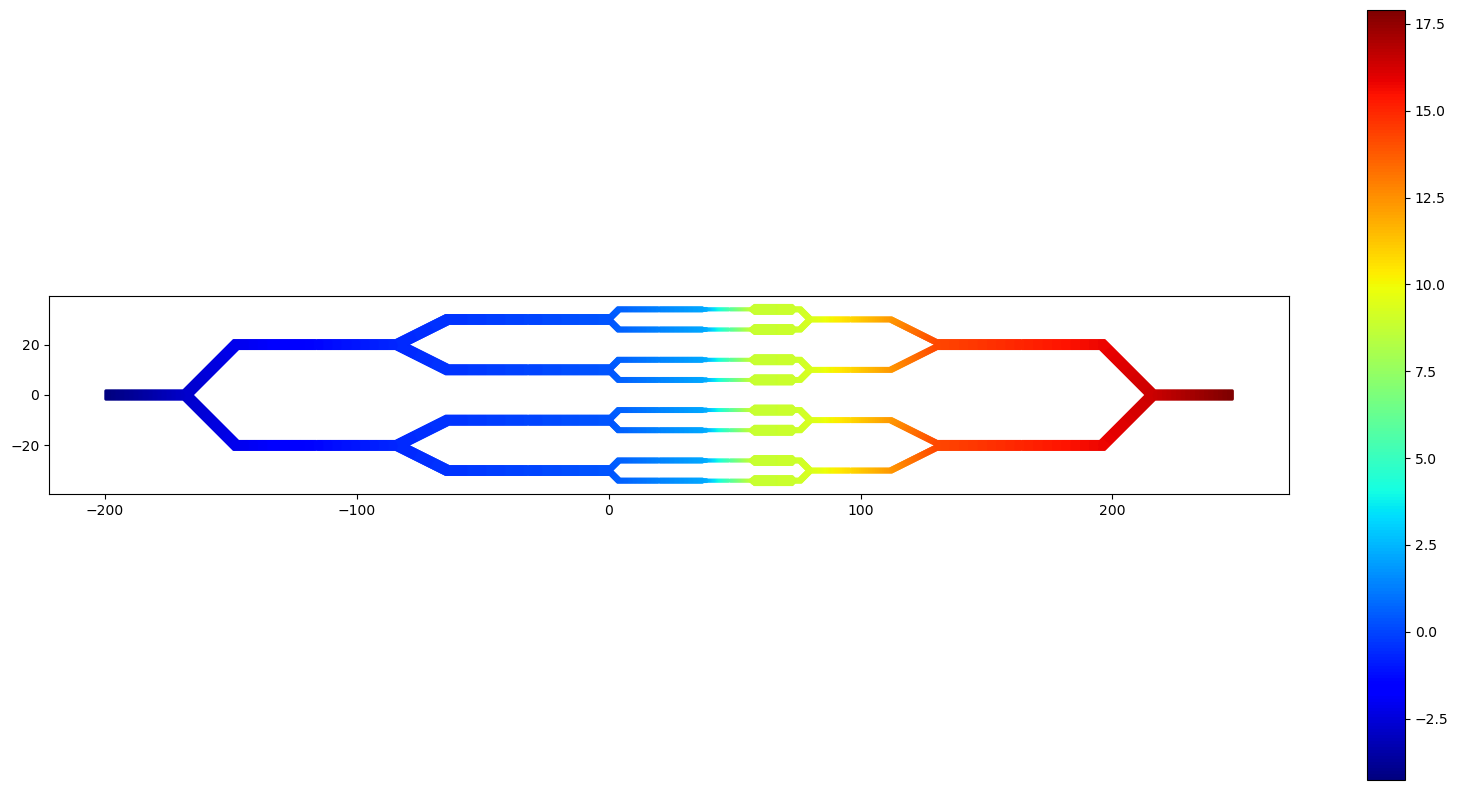

In [13]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')
im = ax.scatter(xs,ys,c=p_field,s=0.1,cmap='jet')
fig.colorbar(im)

In [14]:
velocity = global_pipe.velocity(xs,ys,global_pipe.omegas[0])

In [15]:
pressure, vorticity = global_pipe.pressure_and_vorticity(xs,ys,global_pipe.omegas[0])

In [16]:
offset = np.quantile(pressure-p_field,.5)
offset

4.274812430018034

In [17]:
p_diff = np.log10(np.abs(pressure-p_field - offset))
o_diff = np.log10(np.abs(vorticity-o_field))
u_diff = np.log10(np.linalg.norm(np.array([u_field,v_field]) - velocity.T,axis=0))

vmax = np.max(np.array([p_diff,o_diff,u_diff]))
vmin = np.min(np.array([p_diff,o_diff,u_diff]))

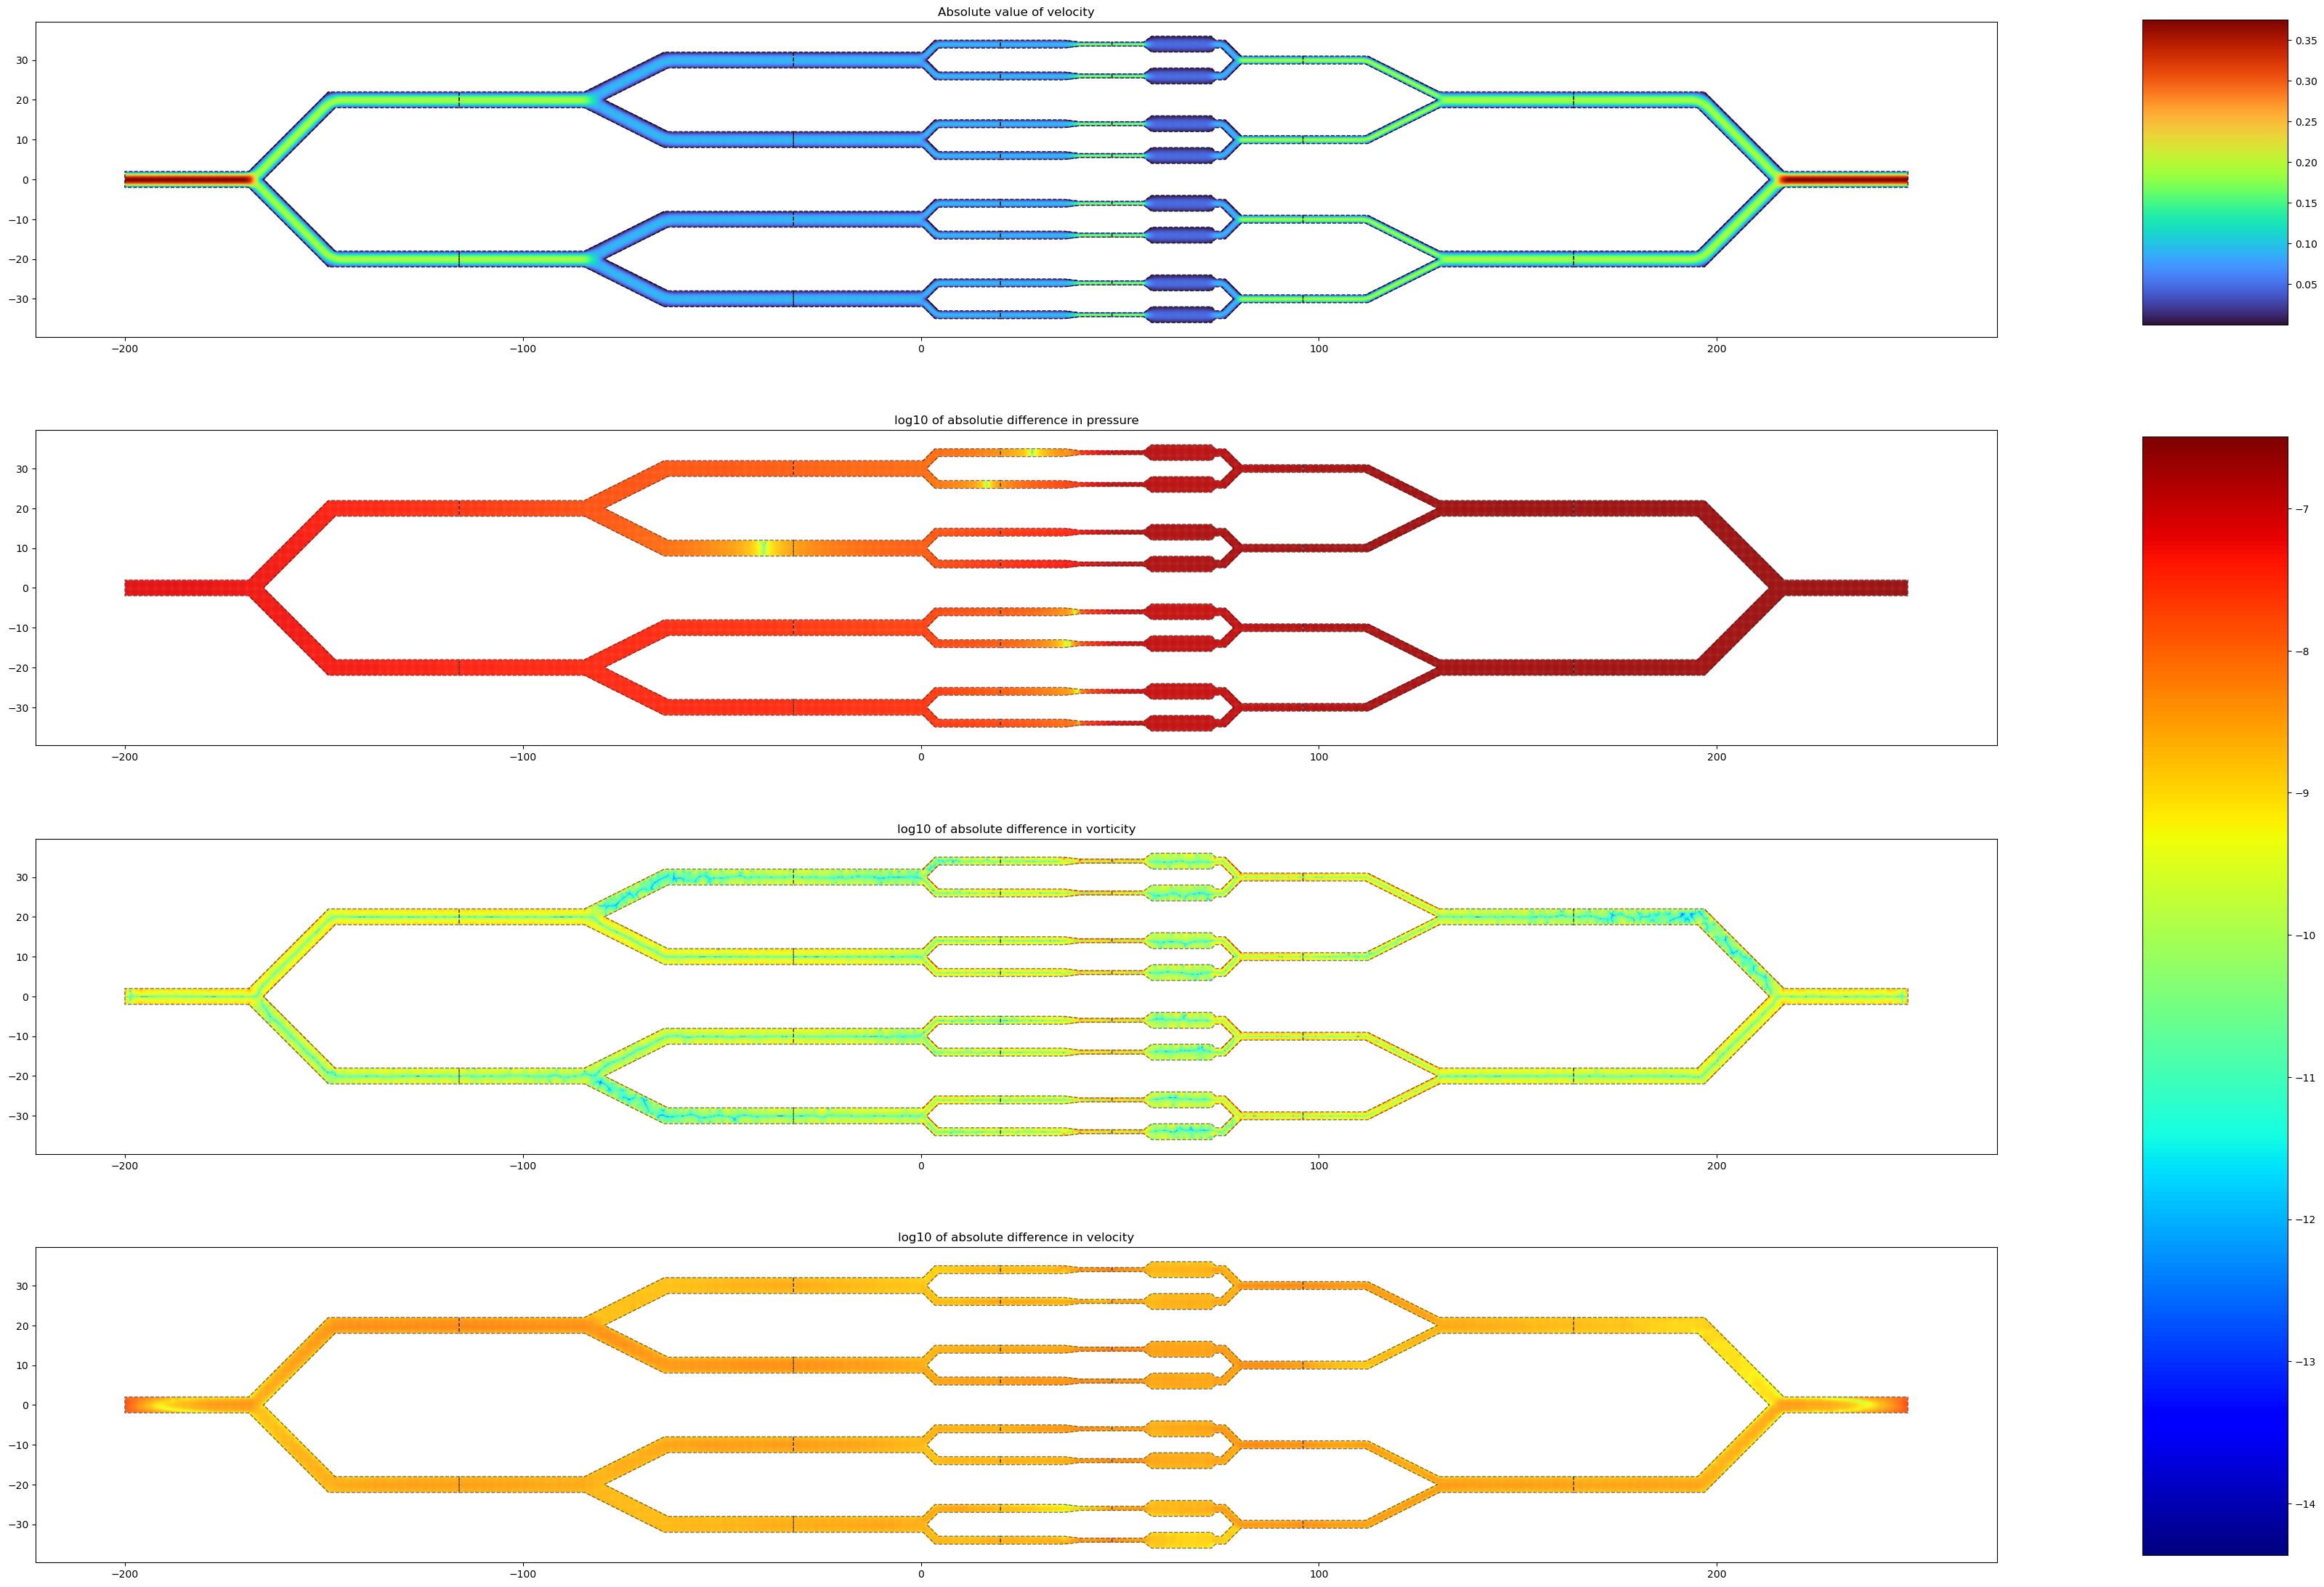

In [18]:
fig, axes = plt.subplots(4,1,figsize=(40,28))

ax = axes[0]
ax.set_aspect('equal')
im1 = ax.scatter(xs,ys,c=np.linalg.norm(np.array([u_field,v_field]),axis=0),s=0.2, cmap='turbo')
ax.set_title("Absolute value of velocity")
# ax.streamplot(xi,yi,ui,vi,density=4,maxlength=2,integration_direction='forward',color='black')

for a,i,j in zip(range(22),pipes,shifts):
    ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,'--k',alpha=0.8,linewidth=1)
    
# draw the streamlines.  

for ax, diff, title in zip(axes[1:], [p_diff, o_diff, u_diff], ['log10 of absolutie difference in pressure', 'log10 of absolute difference in vorticity', 'log10 of absolute difference in velocity']):
    ax.set_aspect('equal')
    im = ax.scatter(xs,ys,c=diff,s=0.1, vmin=vmin,vmax=vmax,cmap='jet')
    ax.set_title(title)
    
    for a,i,j in zip(range(22),pipes,shifts):
        ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,'--k',alpha=0.5,linewidth=1)
    

fig.subplots_adjust(right=0.8)
cbar_ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.55])
fig.colorbar(im, cax=cbar_ax2)
cbar_ax1 = fig.add_axes([0.85, 0.725, 0.05, 0.15])
fig.colorbar(im1, cax=cbar_ax1)

fig.savefig('connecting-demo.png')